# Abstractive Text Summarization using Deep Learning

## Data Preprocessing and Cleaning

In [1]:
from tqdm import tqdm
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import re

In [2]:
data = pd.read_csv('Data/amazon-fine-food-reviews.csv')
data.drop_duplicates(inplace=True) # dropping duplicates
data.dropna(axis=0, inplace = True) # dropping empty rows
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568411 non-null  int64 
 1   ProductId               568411 non-null  object
 2   UserId                  568411 non-null  object
 3   ProfileName             568411 non-null  object
 4   HelpfulnessNumerator    568411 non-null  int64 
 5   HelpfulnessDenominator  568411 non-null  int64 
 6   Score                   568411 non-null  int64 
 7   Time                    568411 non-null  int64 
 8   Summary                 568411 non-null  object
 9   Text                    568411 non-null  object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [3]:
data = data[:100000]

In [4]:
data = data.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], 1)

C:\Users\asus\AppData\Local\Temp/ipykernel_13296/3557384794.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], 1)


In [5]:
# function to carry out contraction expansions
def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)
    return phrase

In [6]:
def clean(column_name):
    preprocessed_text = []
    for sentence in tqdm(data[column_name].values):
        try:
            sentence = sentence.lower() # converting all letters to lowercase
            sentence = re.sub(r"http\S+", "", sentence) # removing urls
            sentence = BeautifulSoup(sentence, 'lxml').get_text() # removing any html tags
            sentence = re.sub(r'\([^)]*\)', '', sentence) # removing any text inside parantheses
            sentence = cleaner(sentence) # contraction expansions
            sentence = re.sub(r"'s\b","", sentence) # removing apostrophes
            sentence = re.sub("\S*\d\S*", "", sentence).strip() # whitespace
            sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removing special characters, punctuation marks
            preprocessed_text.append(sentence.strip())
        except:
            preprocessed_text.append('')
    return preprocessed_text

In [7]:
data['Cleaned Summary'] = clean('Summary')
print("Summaries have been cleaned.")

  8%|▊         | 8153/100000 [00:01<00:20, 4412.94it/s]C:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: "..." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
100%|██████████| 100000/100000 [00:22<00:00, 4439.43it/s]

Summaries have been cleaned.


In [8]:
data['Cleaned Text'] = clean('Text')
print("Texts have been cleaned.")

100%|██████████| 100000/100000 [00:32<00:00, 3102.22it/s]

Texts have been cleaned.


In [9]:
data.to_csv('Data/Cleaned Data.csv', index = False) # exporting as CSV for external use

In [10]:
data = pd.read_csv('Data/Cleaned Data.csv')
data = data.replace(np.nan, '', regex = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Summary          100000 non-null  object
 1   Text             100000 non-null  object
 2   Cleaned Summary  100000 non-null  object
 3   Cleaned Text     100000 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


In [11]:
for i in range(5):
    print("Review:",data['Cleaned Text'][i])
    print("Summary:",data['Cleaned Summary'][i])
    print("\n")

Review: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most
Summary: good quality dog food


Review: product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo
Summary: not as advertised


Review: this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sist

In [12]:
count = 0
for i in data['Cleaned Summary']:
    if(len(i.split()) <= 10):
        count = count + 1
print(count / len(data['Cleaned Summary']))

0.97373


In [13]:
max_summary_len = 10
max_text_len = 50

In [14]:
cleaned_text =np.array(data['Cleaned Text'])
cleaned_summary=np.array(data['Cleaned Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
data=pd.DataFrame({'text':short_text,'summary':short_summary})

In [15]:
data['summary'] = data['summary'].apply(lambda x : 'START '+ x + ' END')

In [16]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(data['text'], data['summary'], test_size=0.2, random_state=0, shuffle=True) 

## Preparing Tokenizers

In [17]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

### Text Tokenizer

In [18]:
# initializing a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# any word whose word count falls below 4 would be considered a rare word
threshold = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in x_tokenizer.word_counts.items():
    total_count = total_count + 1
    total_frequency = total_frequency + value
    if(value < threshold):
        count = count + 1
        frequency = frequency + value
    
print("Total % of rare words in vocabulary: ", (count / total_count) * 100)
print("Total coverage of rare words in vocabulary: ", (frequency / total_frequency) * 100)

# preparing a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words = total_count - count) 
x_tokenizer.fit_on_texts(list(x_tr))

# converting text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen = max_text_len, padding = 'post')
x_val = pad_sequences(x_val_seq, maxlen = max_text_len, padding = 'post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1
print("Size of reviews vocabulary: ", x_voc)

Total % of rare words in vocabulary:  64.32498772704959
Total coverage of rare words in vocabulary:  1.6614259054788865
Size of reviews vocabulary:  7268


### Summary Tokenizer

In [19]:
# initialzing a tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

# any word whose word count falls below 4 would be considered a rare word
thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in y_tokenizer.word_counts.items():
    total_count = total_count + 1
    total_frequency = total_frequency + value
    if(value < thresh):
        count = count + 1
        frequency = frequency + value
    
print("% of rare words in vocabulary:", (count / total_count) * 100)
print("Total Coverage of rare words:", (frequency / total_frequency) * 100)

# preparing a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words = total_count-count) 
y_tokenizer.fit_on_texts(list(y_tr))

# converting text sequences into integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# padding zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen = max_summary_len, padding = 'post')
y_val = pad_sequences(y_val_seq, maxlen = max_summary_len, padding = 'post')

# size of vocabulary
y_voc = y_tokenizer.num_words + 1
print("Size of summary vocabulary: ", y_voc)

% of rare words in vocabulary: 69.59027690765568
Total Coverage of rare words: 4.157945920805057
Size of summary vocabulary:  2428


In [20]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)
y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)
y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Model Building

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [22]:
from attention import AttentionLayer

In [23]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape = (max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable = True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape = (None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis= -1, name = 'concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      726800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [24]:
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')

In [25]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [26]:
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], epochs = 25, callbacks = [es], batch_size = 256, validation_data = ([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/25
135/135 [==============================] - 1247s 9s/step - loss: 2.5872 - val_loss: 2.2258
Epoch 2/25
135/135 [==============================] - 1504s 11s/step - loss: 2.2167 - val_loss: 2.1471
Epoch 3/25
135/135 [==============================] - 1536s 11s/step - loss: 2.1365 - val_loss: 2.0659
Epoch 4/25
135/135 [==============================] - 1532s 11s/step - loss: 2.0560 - val_loss: 2.0025
Epoch 5/25
135/135 [==============================] - 1386s 10s/step - loss: 1.9707 - val_loss: 1.9325
Epoch 6/25
135/135 [==============================] - 1423s 11s/step - loss: 1.8969 - val_loss: 1.8760
Epoch 7/25
135/135 [==============================] - 1524s 11s/step - loss: 1.8344 - val_loss: 1.8374
Epoch 8/25
135/135 [==============================] - 1452s 11s/step - loss: 1.7850 - val_loss: 1.8123
Epoch 9/25
135/135 [==============================] - 1555s 12s/step - loss: 1.7378 - val_loss: 1.7785
Epoch 10/25
135/135 [==============================] - 4182s 31s/step - lo

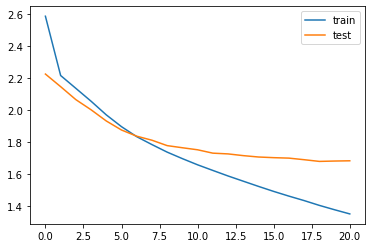

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [28]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## Inference

In [29]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
decoder_hidden_state_input = Input(shape = (max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [30]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token != 'end'):
            decoded_sentence += ' '+sampled_token
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [31]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [32]:
for i in range(0, 100):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_val[i].reshape(1, max_text_len)))
    print("\n")

Review: not a bad tea just nothing special i like to add mint and agave syrup to it to enhance the flavor 
Original summary: ok tea 
Predicted summary:  great tea


Review: this is good popcorn but it is very small so you need to make twice as much as you normally would 
Original summary: small 
Predicted summary:  great taste


Review: these tortilla chips are delicious and they do not contain any bad oils or artificial ingredients i am following the perfect diet and these fit on the diet nicely only way this could be better would be if ingredients were all organic 
Original summary: really enjoyed these 
Predicted summary:  very good


Review: this is an excellent full bodied coffee without a bitter taste in general the wolfgang puck coffees are quite good although a little more expensive than some of the other k cups 
Original summary: excellent coffee 
Predicted summary:  great product


Review: this makes a tasty low calorie soup i often add extra vegetables and even a few noodles

In [33]:
model.save('model.h5')

In [34]:
model.save("Models/Text Summarization")

INFO:tensorflow:Assets written to: Models/Text Summarization\assets
